# Kepler Exoplanet Detection - Complete Machine Learning Pipeline v6

This notebook creates a comprehensive machine learning pipeline for exoplanet detection using the **Kepler Space Telescope** dataset.

## About Kepler Mission
The Kepler Space Telescope was NASA's first mission capable of finding Earth-size planets around sun-like stars. Operating from 2009 to 2018, Kepler discovered thousands of exoplanets and revolutionized our understanding of planetary systems.

## Project Objective
Using the **Kepler Objects of Interest (KOI)** dataset to develop a 3-class classification model:
- **Candidate**: Planet candidates requiring further validation
- **Confirmed**: Confirmed planets through follow-up observations  
- **False_Positive**: Objects that were initially detected but later ruled out as planets

## Dataset Information
- **Source**: NASA Exoplanet Archive - Kepler Objects of Interest
- **Size**: ~9,500+ KOI objects
- **Features**: 141 parameters including orbital period, transit depth, stellar properties
- **Time Range**: 2009-2018 Kepler mission data

## Pipeline Steps
1. **Data Loading and Initial Exploratory Analysis**
2. **Data Preprocessing and Cleaning**
3. **Feature Engineering and Selection**
4. **Model Development and Training**
5. **Model Evaluation and Optimization**
6. **Results Analysis and Model Deployment**

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# XGBoost and LightGBM
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. To install: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not installed. To install: pip install lightgbm")

# Graphics settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Libraries loaded successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")

Libraries loaded successfully!
XGBoost available: True
LightGBM available: True


## 1. Data Loading and Initial Exploratory Analysis

Loading and exploring the Kepler Objects of Interest (KOI) dataset from NASA's Exoplanet Archive.

In [14]:
# Load Kepler dataset
data_path = "../kepler/kepler.csv"
df = pd.read_csv(data_path)

print("=== Kepler Dataset General Information ===")
print(f"Dataset size: {df.shape}")
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")
print("\n=== First 5 rows ===")
df.head()

=== Kepler Dataset General Information ===
Dataset size: (9564, 141)
Number of columns: 141
Number of rows: 9564

=== First 5 rows ===


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [15]:
# Dataset information
print("=== Data Types ===")
print(df.dtypes.value_counts())
print(f"\nNumerical columns: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"Categorical columns: {df.select_dtypes(include=['object']).shape[1]}")

print("\n=== Missing Values Analysis ===")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Percentage', ascending=False)

print("Columns with most missing values:")
print(missing_info[missing_info['Missing_Count'] > 0].head(10))

=== Data Types ===
float64    117
object      17
int64        7
Name: count, dtype: int64

Numerical columns: 124
Categorical columns: 17

=== Missing Values Analysis ===
Columns with most missing values:
                  Missing_Count  Missing_Percentage
koi_model_dof              9564               100.0
koi_teq_err1               9564               100.0
koi_ingress_err1           9564               100.0
koi_ingress                9564               100.0
koi_sage_err2              9564               100.0
koi_sage_err1              9564               100.0
koi_sma_err1               9564               100.0
koi_longp_err2             9564               100.0
koi_longp_err1             9564               100.0
koi_longp                  9564               100.0

Numerical columns: 124
Categorical columns: 17

=== Missing Values Analysis ===
Columns with most missing values:
                  Missing_Count  Missing_Percentage
koi_model_dof              9564               100.0
koi_

=== Target Variable Analysis (koi_disposition) ===
Class distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

Total number of classes: 3
Most common class: FALSE POSITIVE (4839 samples)


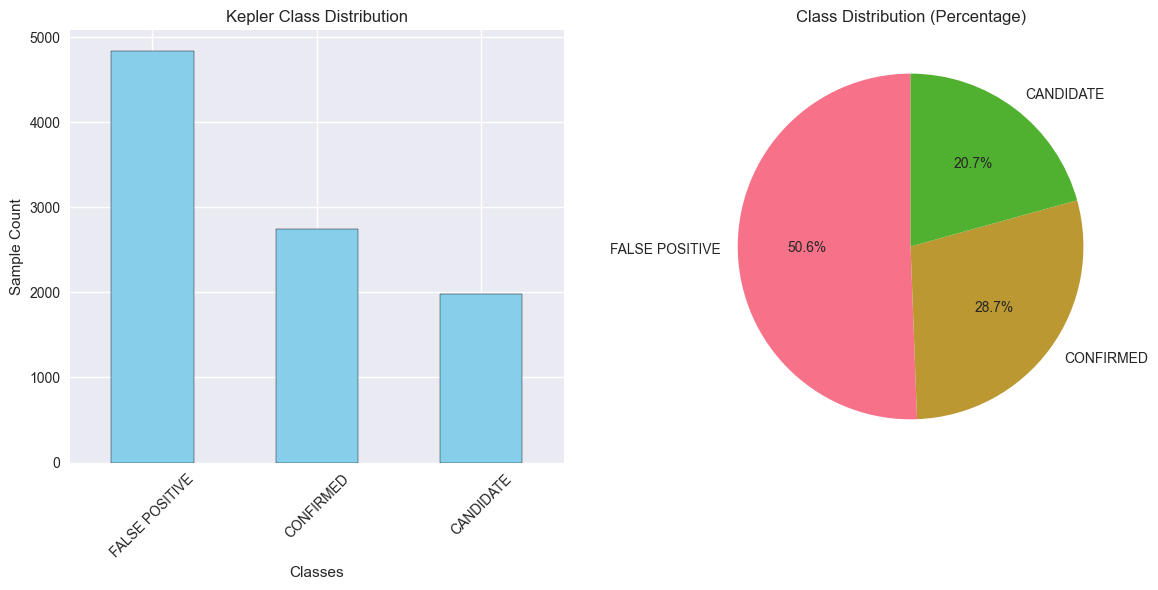


Class descriptions:
CONFIRMED: Confirmed planets
CANDIDATE: Planet candidates
FALSE POSITIVE: False positives


In [16]:
# Target variable analysis (koi_disposition column)
print("=== Target Variable Analysis (koi_disposition) ===")
print("Class distribution:")
class_counts = df['koi_disposition'].value_counts()
print(class_counts)

print(f"\nTotal number of classes: {len(class_counts)}")
print(f"Most common class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")

# Visualization of class distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Kepler Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print("\nClass descriptions:")
print("CONFIRMED: Confirmed planets")
print("CANDIDATE: Planet candidates") 
print("FALSE POSITIVE: False positives")

## 2. Data Preprocessing and Cleaning

Cleaning the KOI dataset and creating a balanced 3-class target variable for machine learning.

In [17]:
# Create 3-class target variable
def create_3class_target(disposition_value):
    """
    Converts Kepler koi_disposition values to 3 classes:
    - Candidate (0): CANDIDATE - Planet candidates
    - Confirmed (1): CONFIRMED - Confirmed planets
    - False_Positive (2): FALSE POSITIVE - False positives
    """
    if disposition_value == 'CANDIDATE':
        return 0  # Candidate
    elif disposition_value == 'CONFIRMED':
        return 1  # Confirmed
    elif disposition_value == 'FALSE POSITIVE':
        return 2  # False_Positive
    else:
        return -1  # Unknown

# Create 3-class target variable
df['target_3class'] = df['koi_disposition'].apply(create_3class_target)

# Remove unknown classes
unknown_mask = df['target_3class'] == -1
print(f"Samples with unknown class: {unknown_mask.sum()}")

if unknown_mask.sum() > 0:
    print("Unknown classes:")
    print(df[unknown_mask]['koi_disposition'].value_counts())
    
df_clean = df[df['target_3class'] != -1].copy()

print(f"\nCleaned dataset size: {df_clean.shape}")
print("\n3-class target variable distribution:")
target_counts = df_clean['target_3class'].value_counts().sort_index()
target_names = ['Candidate', 'Confirmed', 'False_Positive']
for i, (count, name) in enumerate(zip(target_counts, target_names)):
    print(f"{i} - {name}: {count} samples ({count/len(df_clean)*100:.1f}%)")

Samples with unknown class: 0


Cleaned dataset size: (9564, 142)

3-class target variable distribution:
0 - Candidate: 1979 samples (20.7%)
1 - Confirmed: 2746 samples (28.7%)
2 - False_Positive: 4839 samples (50.6%)

Cleaned dataset size: (9564, 142)

3-class target variable distribution:
0 - Candidate: 1979 samples (20.7%)
1 - Confirmed: 2746 samples (28.7%)
2 - False_Positive: 4839 samples (50.6%)


In [18]:
# Feature selection and cleaning
print("=== Feature Selection ===")

# Define columns to exclude
exclude_columns = [
    'rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'target_3class',  # ID and target columns
    'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_disp_prov', 'koi_comment',  # Status columns
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',  # Flag columns
    'koi_fittype', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_sparprov',  # Model columns
    'koi_tce_delivname', 'koi_quarters', 'koi_trans_mod',  # Processing columns
    'koi_datalink_dvr', 'koi_datalink_dvs',  # Link columns
    'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1'  # Limb darkening coefficients
]

# Select numerical features
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
feature_columns = [col for col in numerical_columns if col not in exclude_columns]

print(f"Total numerical columns: {len(numerical_columns)}")
print(f"Number of features to use: {len(feature_columns)}")
print(f"Number of excluded columns: {len(exclude_columns)}")

# Create feature matrix
X = df_clean[feature_columns].copy()
y = df_clean['target_3class'].copy()

print(f"\nFeature matrix size: {X.shape}")
print(f"Target variable size: {y.shape}")

# Show used features
print(f"\nUsed features ({len(feature_columns)} total):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")
    
    if i % 5 == 0:  # Empty line after every 5 features
        print()

=== Feature Selection ===
Total numerical columns: 125
Number of features to use: 114
Number of excluded columns: 28

Feature matrix size: (9564, 114)
Target variable size: (9564,)

Used features (114 total):
 1. koi_score
 2. koi_period
 3. koi_period_err1
 4. koi_period_err2
 5. koi_time0bk

 6. koi_time0bk_err1
 7. koi_time0bk_err2
 8. koi_time0
 9. koi_time0_err1
10. koi_time0_err2

11. koi_eccen
12. koi_eccen_err1
13. koi_eccen_err2
14. koi_longp
15. koi_longp_err1

16. koi_longp_err2
17. koi_impact
18. koi_impact_err1
19. koi_impact_err2
20. koi_duration

21. koi_duration_err1
22. koi_duration_err2
23. koi_ingress
24. koi_ingress_err1
25. koi_ingress_err2

26. koi_depth
27. koi_depth_err1
28. koi_depth_err2
29. koi_ror
30. koi_ror_err1

31. koi_ror_err2
32. koi_srho
33. koi_srho_err1
34. koi_srho_err2
35. koi_prad

36. koi_prad_err1
37. koi_prad_err2
38. koi_sma
39. koi_sma_err1
40. koi_sma_err2

41. koi_incl
42. koi_incl_err1
43. koi_incl_err2
44. koi_teq
45. koi_teq_err1

46. k

In [19]:
# Missing value analysis and processing
print("=== Missing Value Processing ===")

missing_info = X.isnull().sum()
missing_features = missing_info[missing_info > 0].sort_values(ascending=False)

print(f"Number of features with missing values: {len(missing_features)}")
print(f"Total number of missing values: {missing_info.sum()}")

if len(missing_features) > 0:
    print("\nFeatures with most missing values:")
    for feature, count in missing_features.head(10).items():
        percentage = (count / len(X)) * 100
        print(f"{feature}: {count} ({percentage:.1f}%)")

    # Remove features with too many missing values (>25% missing)
    high_missing_threshold = 0.25
    high_missing_features = missing_features[missing_features / len(X) > high_missing_threshold].index.tolist()
    
    if len(high_missing_features) > 0:
        print(f"\nRemoving features with >{high_missing_threshold*100}% missing values:")
        print(high_missing_features)
        X = X.drop(columns=high_missing_features)
        
    print(f"\nNumber of features after processing: {X.shape[1]}")

# Fill remaining missing values
if X.isnull().sum().sum() > 0:
    print("\nRemaining missing values will be filled with median...")
    imputer = SimpleImputer(strategy='median')
    X_filled = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    print(f"Total missing values after processing: {X_filled.isnull().sum().sum()}")
    X = X_filled
else:
    print("No missing values found.")

=== Missing Value Processing ===
Number of features with missing values: 107
Total number of missing values: 224365

Features with most missing values:
koi_longp: 9564 (100.0%)
koi_ingress_err2: 9564 (100.0%)
koi_ingress: 9564 (100.0%)
koi_sma_err1: 9564 (100.0%)
koi_sma_err2: 9564 (100.0%)
koi_incl_err1: 9564 (100.0%)
koi_incl_err2: 9564 (100.0%)
koi_teq_err1: 9564 (100.0%)
koi_longp_err2: 9564 (100.0%)
koi_longp_err1: 9564 (100.0%)

Removing features with >25.0% missing values:
['koi_longp', 'koi_ingress_err2', 'koi_ingress', 'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 'koi_incl_err2', 'koi_teq_err1', 'koi_longp_err2', 'koi_longp_err1', 'koi_ingress_err1', 'koi_eccen_err2', 'koi_eccen_err1', 'koi_teq_err2', 'koi_model_dof', 'koi_model_chisq', 'koi_sage', 'koi_sage_err1', 'koi_sage_err2']

Number of features after processing: 95

Remaining missing values will be filled with median...
Total missing values after processing: 0


## 3. Exploratory Data Analysis and Visualization

Analyzing the distribution and characteristics of Kepler Objects of Interest (KOI) features.

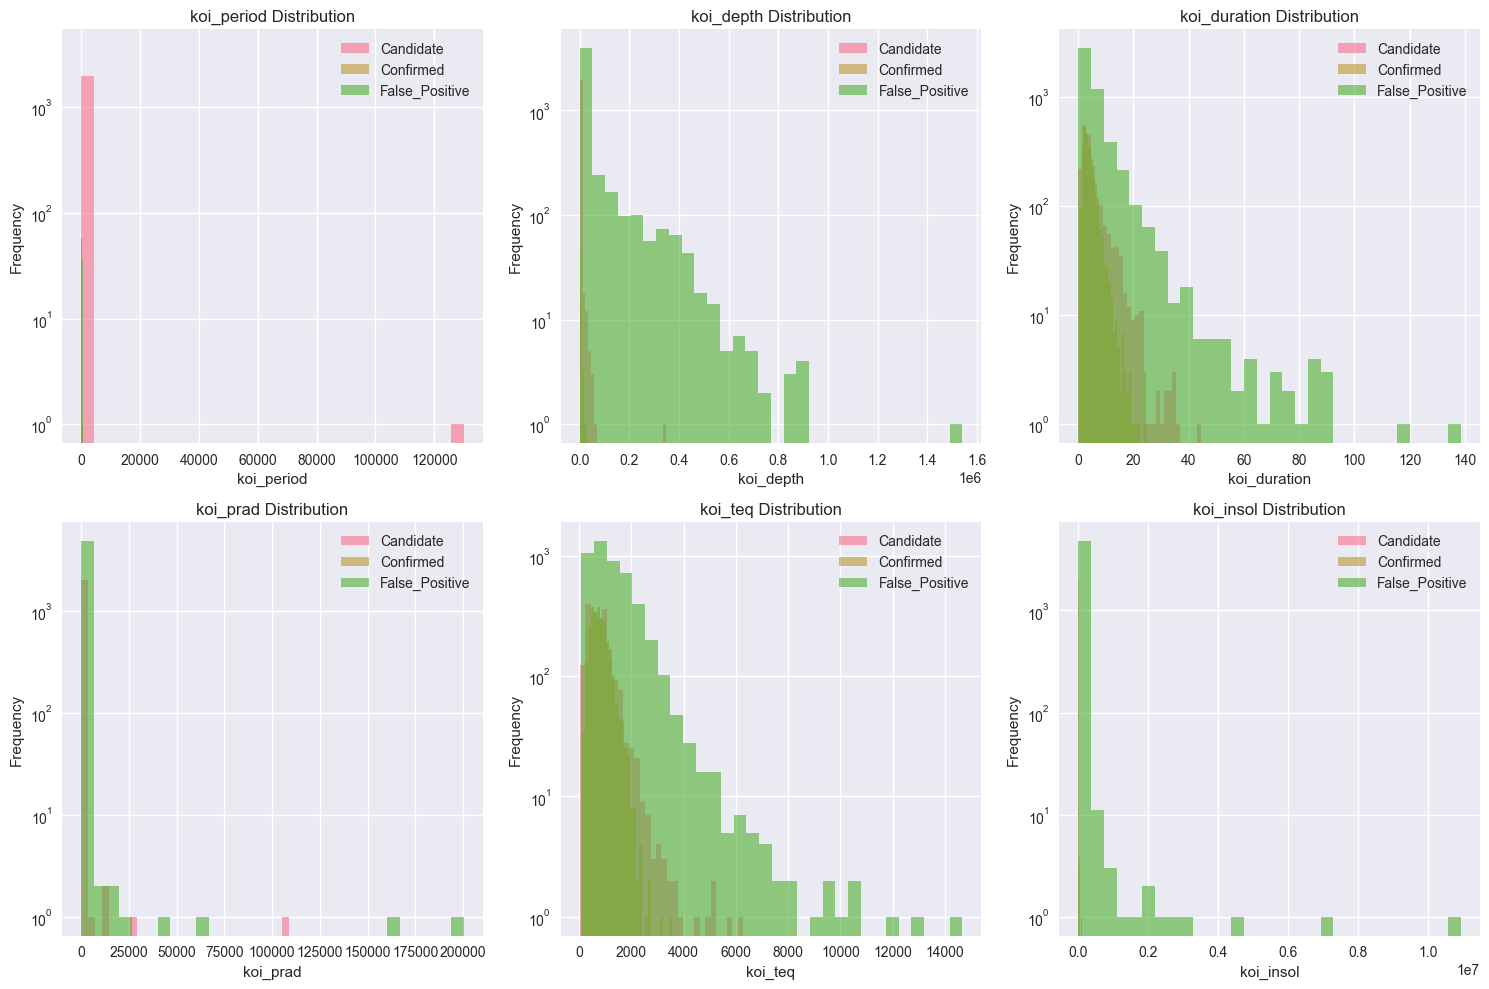

In [20]:
# Analyze distribution of important features for Kepler dataset
# Kepler dataset'inde KOI parametreleri önemli
important_features = ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_steff', 'koi_srad']
available_features = [feat for feat in important_features if feat in X.columns]

if len(available_features) > 0:
    plt.figure(figsize=(15, 10))
    target_names = ['Candidate', 'Confirmed', 'False_Positive']
    
    for i, feature in enumerate(available_features[:6], 1):
        plt.subplot(2, 3, i)
        
        for target_class in range(3):
            mask = y == target_class
            if mask.sum() > 0:
                data = X.loc[mask, feature].dropna()
                if len(data) > 0:
                    plt.hist(data, alpha=0.6, label=target_names[target_class], bins=30)
        
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'{feature} Distribution')
        plt.legend()
        plt.yscale('log')  # Use log scale
    
    plt.tight_layout()
    plt.show()
else:
    print("No important features found for visualization.")

=== Correlation Analysis ===
Number of feature pairs with correlation > 0.9: 54

Highly correlated feature pairs:
koi_period - koi_dor: 0.989
koi_period - koi_dor_err1: 0.988
koi_period - koi_dor_err2: -0.988
koi_period_err1 - koi_period_err2: -1.000
koi_time0bk - koi_time0: 1.000
koi_time0bk_err1 - koi_time0bk_err2: -1.000
koi_time0bk_err1 - koi_time0_err1: 1.000
koi_time0bk_err1 - koi_time0_err2: -1.000
koi_time0bk_err2 - koi_time0_err1: -1.000
koi_time0bk_err2 - koi_time0_err2: 1.000


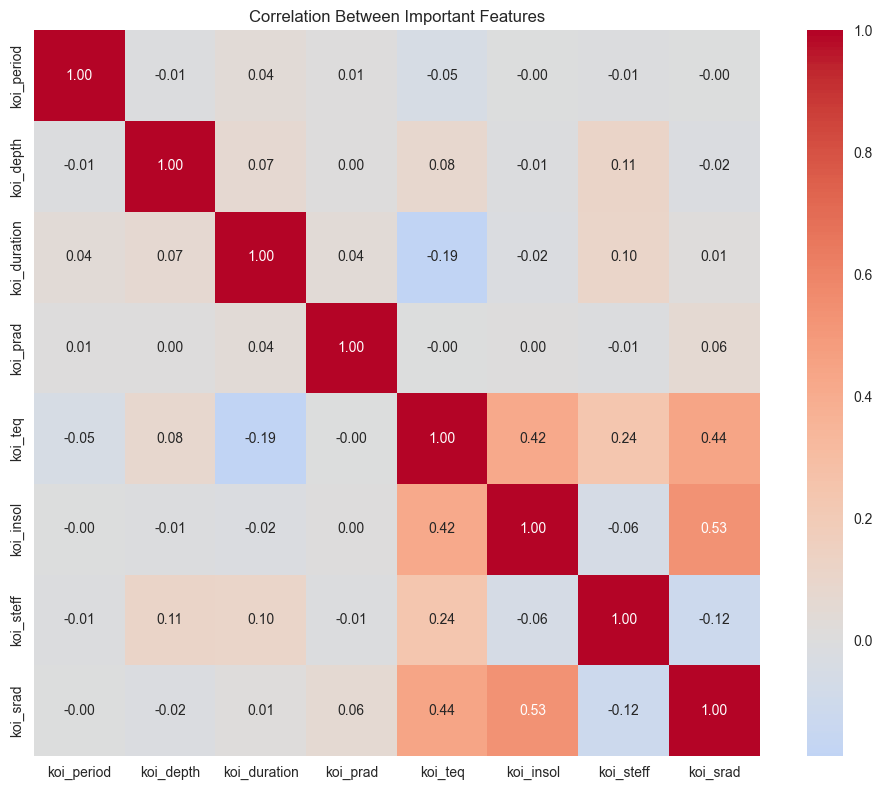

In [21]:
# Correlation analysis
print("=== Correlation Analysis ===")

# Calculate correlation of numerical features
correlation_matrix = X.corr()

# Find highly correlated feature pairs
def find_high_correlation_pairs(corr_matrix, threshold=0.9):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_matrix.iloc[i, j]
                ))
    return high_corr_pairs

high_corr = find_high_correlation_pairs(correlation_matrix, 0.9)
print(f"Number of feature pairs with correlation > 0.9: {len(high_corr)}")

if len(high_corr) > 0:
    print("\nHighly correlated feature pairs:")
    for feat1, feat2, corr_val in high_corr[:10]:  # Show first 10 pairs
        print(f"{feat1} - {feat2}: {corr_val:.3f}")

# Visualize most important correlations (only important features)
if len(available_features) > 1:
    available_corr = correlation_matrix.loc[available_features, available_features]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(available_corr, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Correlation Between Important Features')
    plt.tight_layout()
    plt.show()

## 4. Feature Engineering and Selection

Engineering and selecting the most informative KOI parameters for classification.

In [22]:
# Remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.95):
    """Removes one of the highly correlated features."""
    corr_matrix = X.corr().abs()
    
    # Get upper triangle
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find highly correlated features
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    
    return X.drop(columns=to_drop), to_drop

X_reduced, dropped_features = remove_highly_correlated_features(X, threshold=0.95)
print(f"Number of features removed due to high correlation: {len(dropped_features)}")
print(f"Remaining number of features: {X_reduced.shape[1]}")

if len(dropped_features) > 0:
    print("Removed features:")
    for feature in dropped_features:
        print(f"- {feature}")

X = X_reduced

Number of features removed due to high correlation: 25
Remaining number of features: 70
Removed features:
- koi_period_err2
- koi_time0bk_err2
- koi_time0
- koi_time0_err1
- koi_time0_err2
- koi_duration_err2
- koi_depth_err2
- koi_ror
- koi_ror_err1
- koi_ror_err2
- koi_prad_err2
- koi_insol_err2
- koi_dor
- koi_dor_err1
- koi_dor_err2
- koi_gmag
- koi_rmag
- koi_hmag
- koi_kmag
- koi_fwm_sra
- koi_fwm_sdec
- koi_fwm_sdec_err
- koi_fwm_srao_err
- koi_fwm_sdeco_err
- koi_fwm_pdeco_err


In [23]:
# Statistical feature selection
print("=== Statistical Feature Selection ===")

# Select best k features with F-score
k_best = min(20, X.shape[1])  # Select at most 20 features
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X, y)

# Get names of selected features
selected_features = X.columns[selector.get_support()].tolist()
feature_scores = selector.scores_[selector.get_support()]

# Show feature scores
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'F_Score': feature_scores
}).sort_values('F_Score', ascending=False)

print(f"Number of selected features: {len(selected_features)}")
print("\nFeatures with highest F-scores:")
print(feature_importance_df.head(10))

# Convert selected features to DataFrame
X_final = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
print(f"\nFinal feature matrix size: {X_final.shape}")

=== Statistical Feature Selection ===
Number of selected features: 20

Features with highest F-scores:
            Feature       F_Score
0         koi_score  14892.082478
4         koi_count   1177.439594
11    koi_smet_err2   1058.225898
6    koi_steff_err1    879.114678
10    koi_smet_err1    804.392289
16   koi_dicco_msky    667.366013
7    koi_steff_err2    657.302884
19   koi_dikco_msky    653.324031
14  koi_fwm_sra_err    592.860787
2          koi_incl    578.158705

Final feature matrix size: (9564, 20)


## 5. Train-Test Split

Splitting the Kepler dataset while preserving class balance.

In [24]:
# Split dataset into training and testing sets
print("=== Dataset Splitting ===")

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Preserve class balance
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Check class distributions
print("\nTraining set class distribution:")
train_dist = y_train.value_counts().sort_index()
for i, count in enumerate(train_dist):
    print(f"Class {i}: {count} samples ({count/len(y_train)*100:.1f}%)")

print("\nTest set class distribution:")
test_dist = y_test.value_counts().sort_index()
for i, count in enumerate(test_dist):
    print(f"Class {i}: {count} samples ({count/len(y_test)*100:.1f}%)")

# Scale features
print("\n=== Feature Scaling ===")
scaler = RobustScaler()  # More robust against outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features successfully scaled!")

=== Dataset Splitting ===
Training set size: (7651, 20)
Test set size: (1913, 20)

Training set class distribution:
Class 0: 1583 samples (20.7%)
Class 1: 2197 samples (28.7%)
Class 2: 3871 samples (50.6%)

Test set class distribution:
Class 0: 396 samples (20.7%)
Class 1: 549 samples (28.7%)
Class 2: 968 samples (50.6%)

=== Feature Scaling ===
Features successfully scaled!


## 6. Model Development and Training

Training multiple machine learning models on Kepler KOI data.

In [25]:
# Create model dictionary
models = {}

# 1. Random Forest
print("=== Random Forest Model ===")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
models['Random Forest'] = rf_model

# 2. Gradient Boosting
print("=== Gradient Boosting Model ===")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
models['Gradient Boosting'] = gb_model

# 3. Logistic Regression
print("=== Logistic Regression Model ===")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='ovr'  # One-vs-Rest for multi-class
)
models['Logistic Regression'] = lr_model

# 4. XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("=== XGBoost Model ===")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='mlogloss'  # Multi-class logloss
    )
    models['XGBoost'] = xgb_model

# 5. LightGBM (if available)
if LIGHTGBM_AVAILABLE:
    print("=== LightGBM Model ===")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1  # Silent mode
    )
    models['LightGBM'] = lgb_model

print(f"\nTotal {len(models)} models will be trained:")
for model_name in models.keys():
    print(f"- {model_name}")

=== Random Forest Model ===
=== Gradient Boosting Model ===
=== Logistic Regression Model ===
=== XGBoost Model ===
=== LightGBM Model ===

Total 5 models will be trained:
- Random Forest
- Gradient Boosting
- Logistic Regression
- XGBoost
- LightGBM


In [26]:
# Train and evaluate models
print("=== Model Training Started ===")

results = {}
trained_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    trained_models[model_name] = model
    
    # Make predictions on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Multi-class ROC AUC (one-vs-rest)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    except:
        roc_auc = 0.0
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'predictions_proba': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n=== Model Training Completed ===")
print(f"Total {len(trained_models)} models trained successfully.")

=== Model Training Started ===

Training Random Forest...
Accuracy: 0.8521
CV Score: 0.8476 (±0.0067)

Training Gradient Boosting...
Accuracy: 0.8521
CV Score: 0.8476 (±0.0067)

Training Gradient Boosting...
Accuracy: 0.8573
CV Score: 0.8476 (±0.0053)

Training Logistic Regression...
Accuracy: 0.8432
CV Score: 0.8343 (±0.0089)

Training XGBoost...
Accuracy: 0.8583
CV Score: 0.8503 (±0.0062)

Training LightGBM...
Accuracy: 0.8610
CV Score: 0.8489 (±0.0039)

=== Model Training Completed ===
Total 5 models trained successfully.


## 7. Model Performance Comparison

Comparing the performance of different models on Kepler classification task.

=== Model Performance Comparison ===
                     accuracy  precision  recall  f1_score  roc_auc  cv_mean  \
Random Forest          0.8521     0.8451  0.8521    0.8471   0.9659   0.8476   
Gradient Boosting      0.8573     0.8528  0.8573    0.8545   0.9668   0.8476   
Logistic Regression    0.8432     0.8340  0.8432    0.8314   0.9513   0.8343   
XGBoost                0.8583     0.8542  0.8583    0.8558   0.9682   0.8503   
LightGBM               0.8610     0.8574  0.8610    0.8588   0.9678   0.8489   

                     cv_std  
Random Forest        0.0067  
Gradient Boosting    0.0053  
Logistic Regression  0.0089  
XGBoost              0.0062  
LightGBM             0.0039  

Best model: LightGBM (F1-Score: 0.8588)


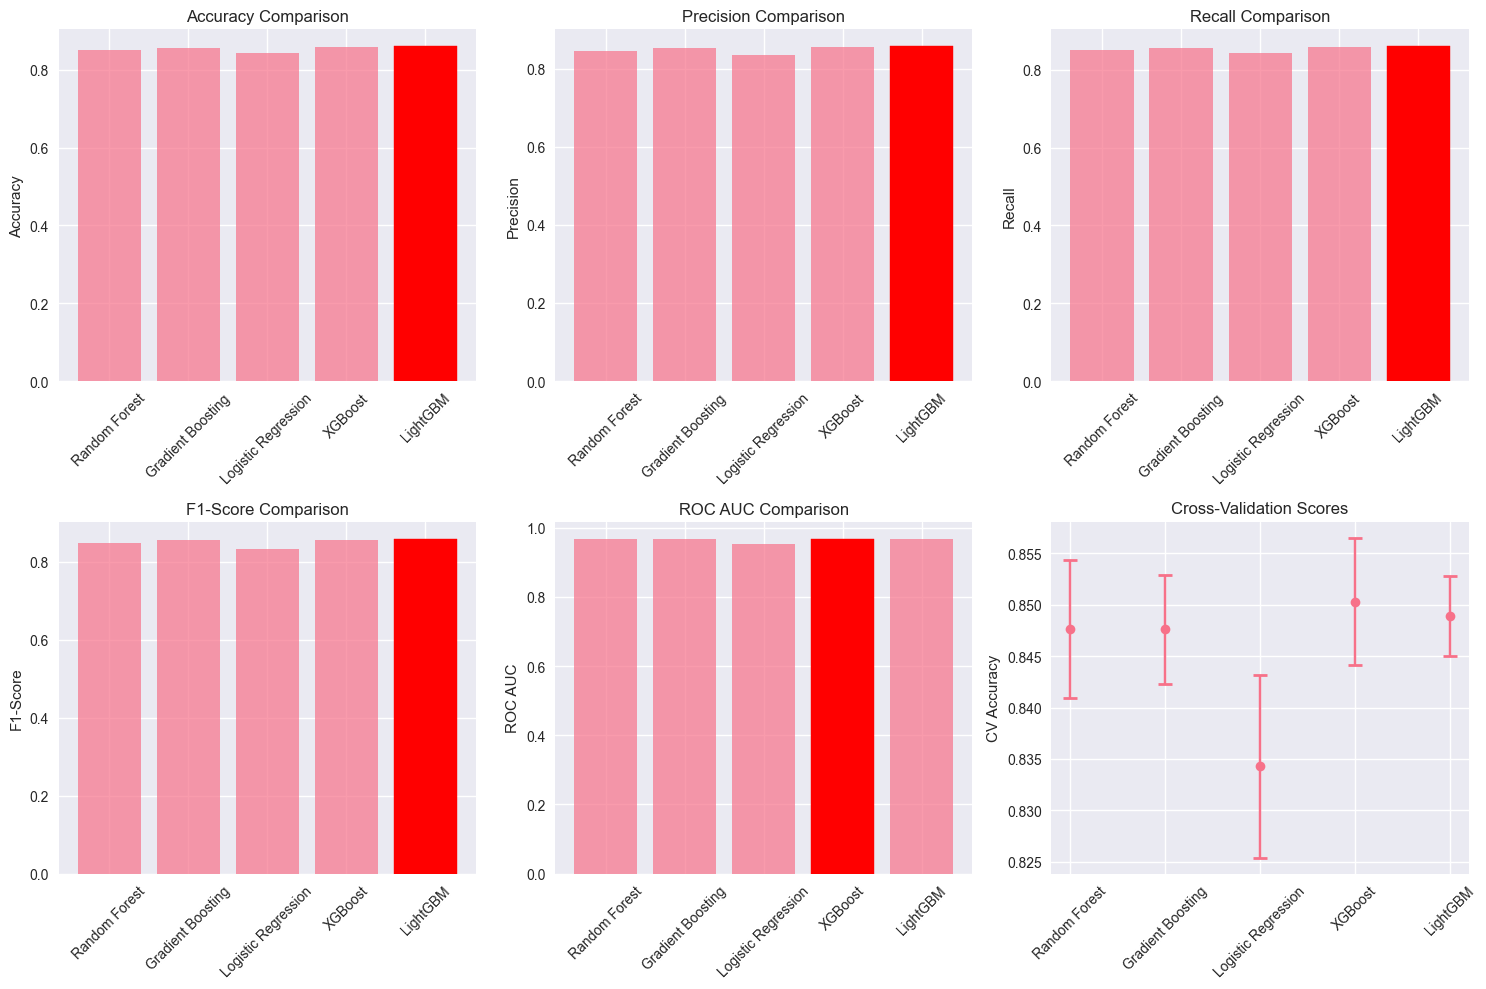

In [27]:
# Compare model performances
comparison_df = pd.DataFrame.from_dict(results, orient='index')
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'cv_mean', 'cv_std']]
comparison_df = comparison_df.round(4)

print("=== Model Performance Comparison ===")
print(comparison_df)

# Determine best model
best_model_name = comparison_df['f1_score'].idxmax()
best_score = comparison_df.loc[best_model_name, 'f1_score']
print(f"\nBest model: {best_model_name} (F1-Score: {best_score:.4f})")

# Performance chart
plt.figure(figsize=(15, 10))

# Metric comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names), 1):
    plt.subplot(2, 3, i)
    bars = plt.bar(comparison_df.index, comparison_df[metric], alpha=0.7)
    plt.title(f'{metric_name} Comparison')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    
    # Highlight best model
    best_idx = comparison_df[metric].idxmax()
    for j, bar in enumerate(bars):
        if comparison_df.index[j] == best_idx:
            bar.set_color('red')
            bar.set_alpha(1.0)

# CV score comparison
plt.subplot(2, 3, 6)
plt.errorbar(range(len(comparison_df)), comparison_df['cv_mean'], 
            yerr=comparison_df['cv_std'], fmt='o', capsize=5, capthick=2)
plt.xticks(range(len(comparison_df)), comparison_df.index, rotation=45)
plt.title('Cross-Validation Scores')
plt.ylabel('CV Accuracy')

plt.tight_layout()
plt.show()

=== LightGBM Detailed Analysis ===

Classification Report:
                precision    recall  f1-score   support

     Candidate       0.70      0.64      0.67       396
     Confirmed       0.89      0.90      0.89       549
False_Positive       0.91      0.93      0.92       968

      accuracy                           0.86      1913
     macro avg       0.83      0.82      0.83      1913
  weighted avg       0.86      0.86      0.86      1913



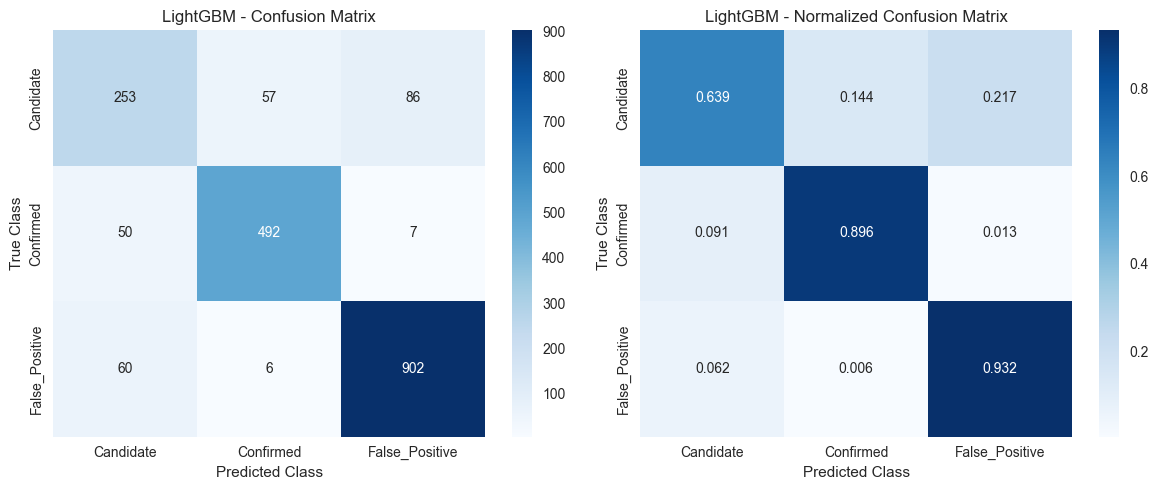


Class-wise Performance:
Candidate: 0.6389 accuracy (396 samples)
Confirmed: 0.8962 accuracy (549 samples)
False_Positive: 0.9318 accuracy (968 samples)


In [28]:
# Detailed analysis of best model
print(f"=== {best_model_name} Detailed Analysis ===")

best_model = trained_models[best_model_name]
best_predictions = results[best_model_name]['predictions']

# Classification report
target_names = ['Candidate', 'Confirmed', 'False_Positive']
print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=target_names))

# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=target_names, yticklabels=target_names)
plt.title(f'{best_model_name} - Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Normalized Confusion Matrix
plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
           xticklabels=target_names, yticklabels=target_names)
plt.title(f'{best_model_name} - Normalized Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.tight_layout()
plt.show()

# Class-wise performance
print("\nClass-wise Performance:")
for i, class_name in enumerate(target_names):
    class_mask = y_test == i
    if class_mask.sum() > 0:
        class_predictions = best_predictions[class_mask]
        class_accuracy = (class_predictions == i).sum() / len(class_predictions)
        print(f"{class_name}: {class_accuracy:.4f} accuracy ({class_mask.sum()} samples)")

## 8. Feature Importance Analysis

Analyzing which KOI parameters are most important for classification.

=== Feature Importance Analysis ===

Random Forest - Top 10 Most Important Features:
               Feature  Importance
0            koi_score    0.338762
11       koi_smet_err2    0.063030
16      koi_dicco_msky    0.054057
13    koi_fwm_stat_sig    0.053880
19      koi_dikco_msky    0.052348
14     koi_fwm_sra_err    0.052175
17  koi_dicco_msky_err    0.040047
6       koi_steff_err1    0.039554
18  koi_dikco_mdec_err    0.036983
1            koi_depth    0.036340

Gradient Boosting - Top 10 Most Important Features:
               Feature  Importance
0            koi_score    0.602609
14     koi_fwm_sra_err    0.093882
1            koi_depth    0.032568
16      koi_dicco_msky    0.031797
17  koi_dicco_msky_err    0.026790
4            koi_count    0.025071
3              koi_teq    0.019883
12      koi_smass_err1    0.019414
5     koi_num_transits    0.018476
19      koi_dikco_msky    0.017737

XGBoost - Top 10 Most Important Features:
               Feature  Importance
0            k

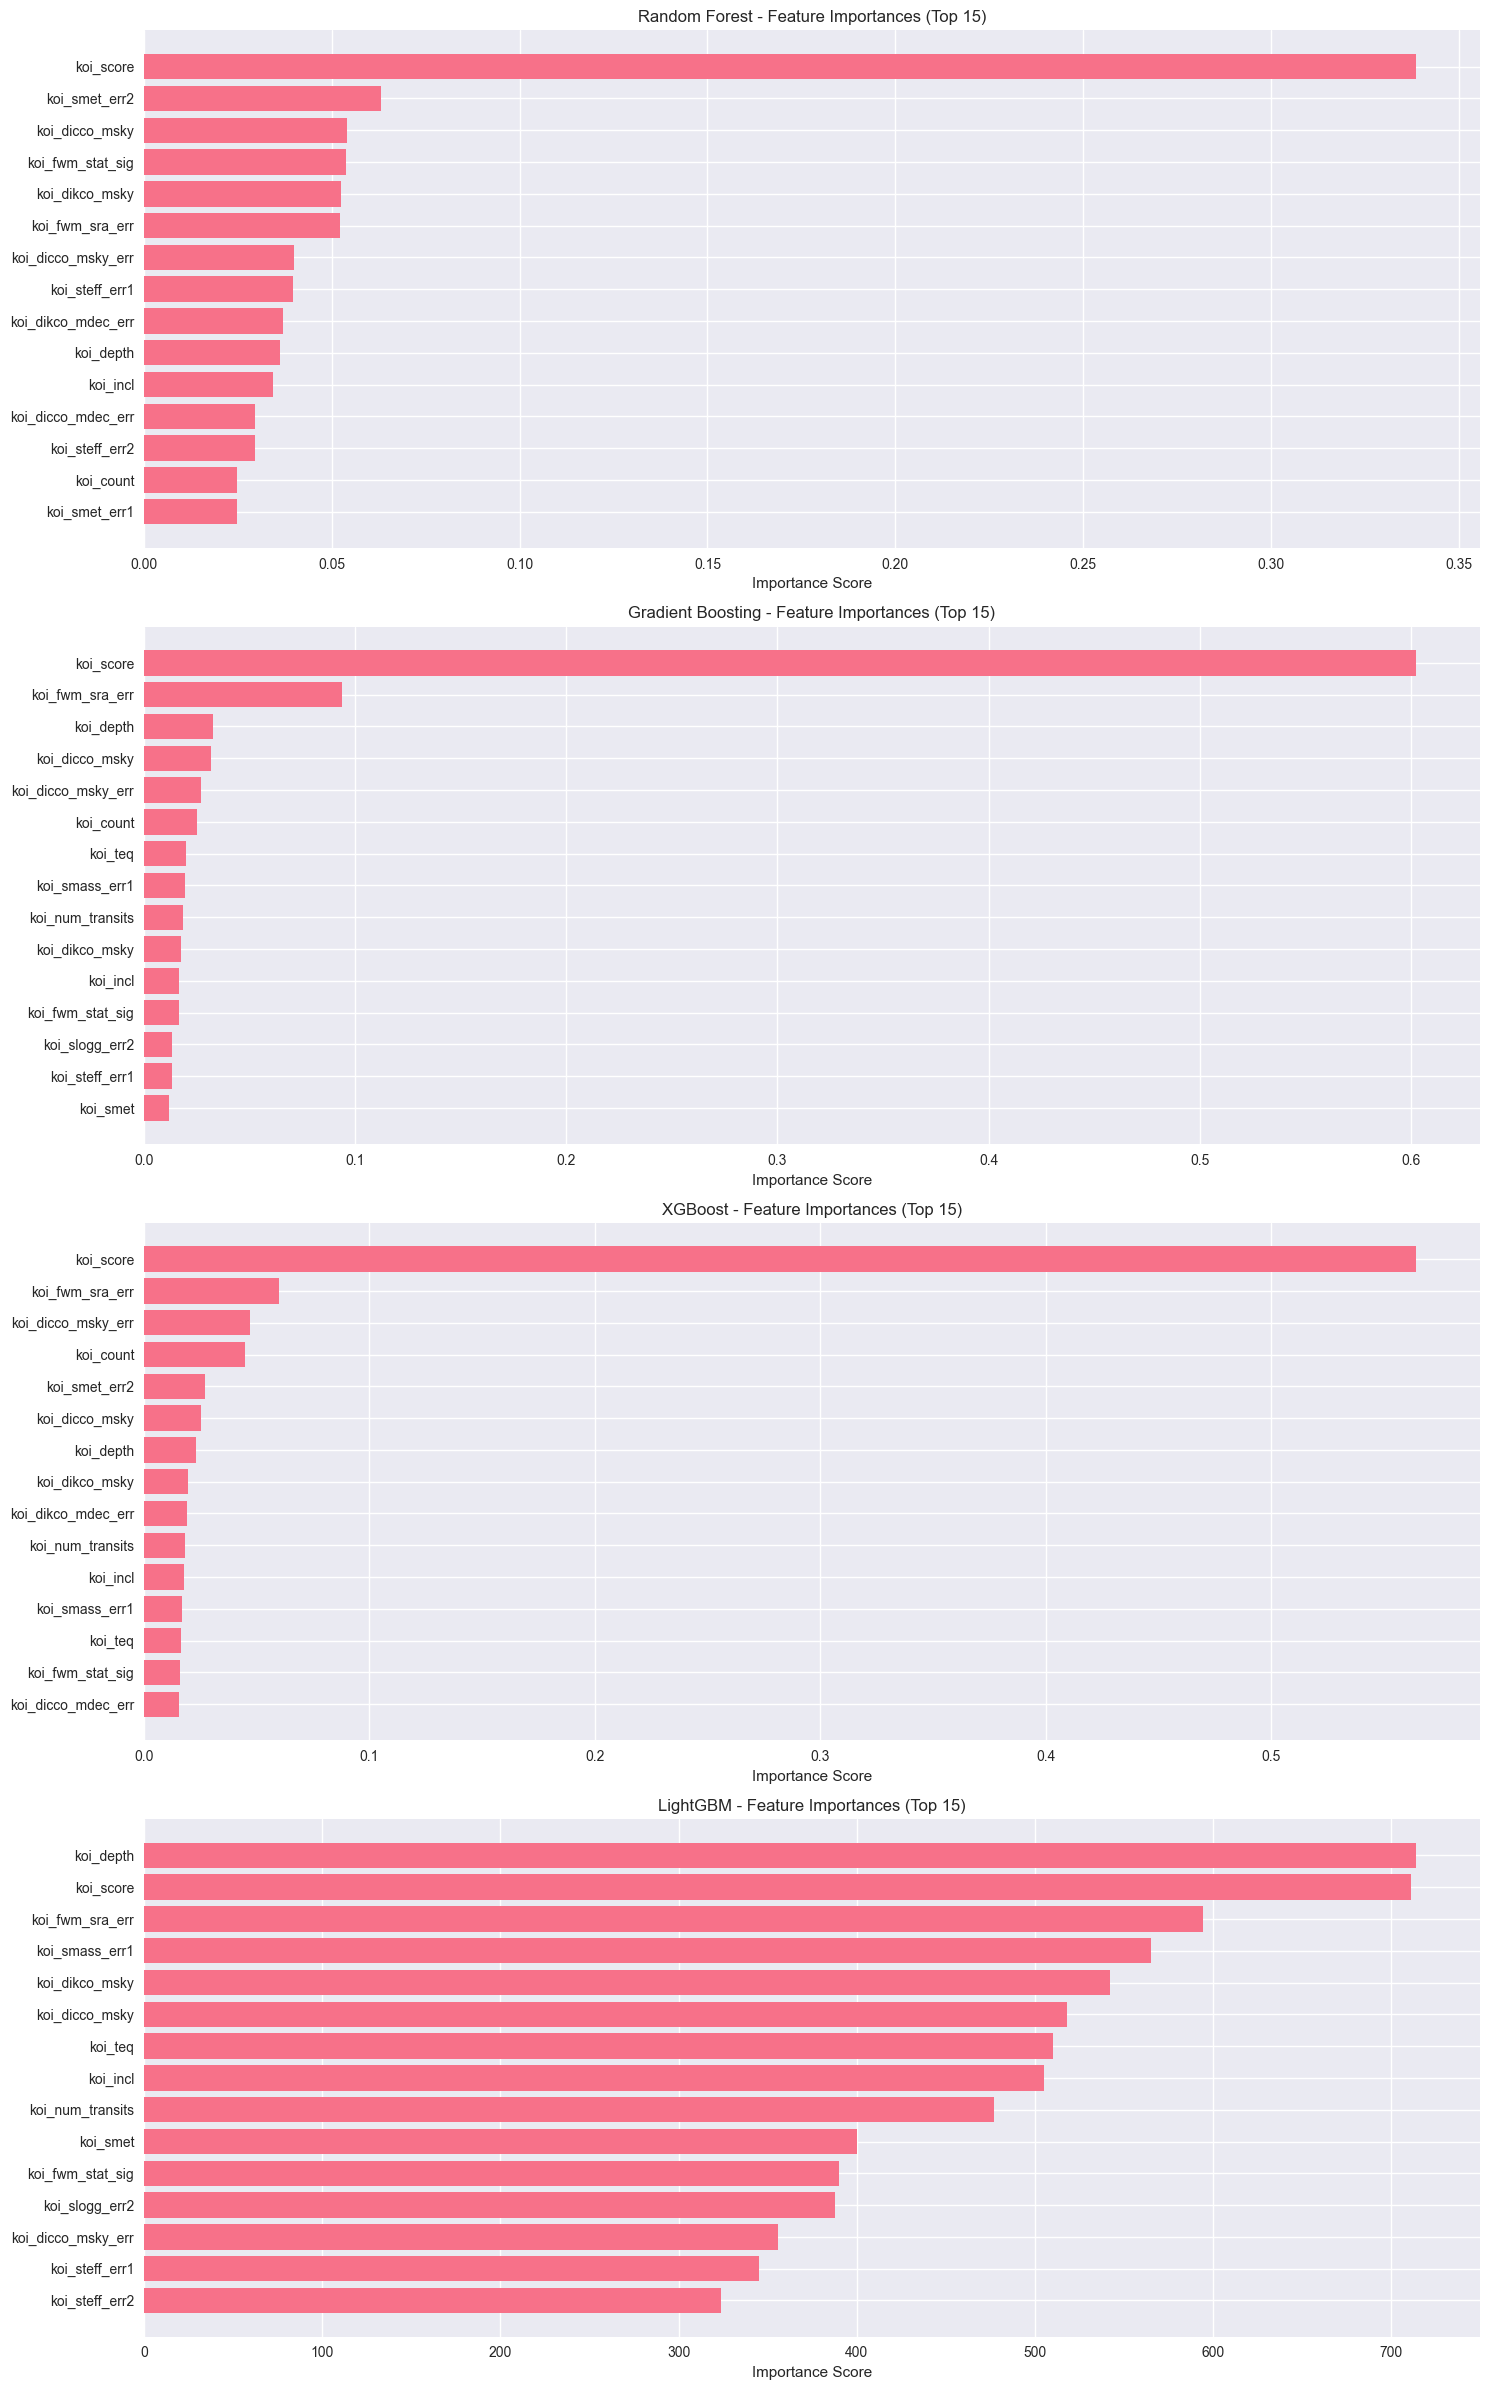

In [29]:
# Feature importance analysis (only for tree-based models)
tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
available_tree_models = [name for name in tree_based_models if name in trained_models]

if len(available_tree_models) > 0:
    print("=== Feature Importance Analysis ===")
    
    plt.figure(figsize=(15, 6 * len(available_tree_models)))
    
    for i, model_name in enumerate(available_tree_models, 1):
        model = trained_models[model_name]
        
        # Get feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            # Create feature importance DataFrame
            importance_df = pd.DataFrame({
                'Feature': X_train_scaled.columns,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print(f"\n{model_name} - Top 10 Most Important Features:")
            print(importance_df.head(10))
            
            # Plot
            plt.subplot(len(available_tree_models), 1, i)
            top_features = importance_df.head(15)
            plt.barh(range(len(top_features)), top_features['Importance'])
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Importance Score')
            plt.title(f'{model_name} - Feature Importances (Top 15)')
            plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("No tree-based models found.")

## 9. Model Optimization (Hyperparameter Tuning)

Optimizing the best performing model for Kepler data classification.

In [30]:
# Optimize the best model
print(f"=== {best_model_name} Optimization ===")

# Define parameter grid based on model type
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.15],
        'max_depth': [6, 8],
        'min_samples_split': [5, 10]
    },
    'Logistic Regression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

if XGBOOST_AVAILABLE:
    param_grids['XGBoost'] = {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.15],
        'max_depth': [6, 8],
        'min_child_weight': [1, 3]
    }

if LIGHTGBM_AVAILABLE:
    param_grids['LightGBM'] = {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.15],
        'max_depth': [6, 8],
        'min_child_samples': [10, 20]
    }

# Perform Grid Search
if best_model_name in param_grids:
    print(f"Starting Grid Search for {best_model_name}...")
    
    base_model = models[best_model_name]
    param_grid = param_grids[best_model_name]
    
    # Use Stratified K-Fold
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        base_model, 
        param_grid, 
        cv=cv, 
        scoring='f1_weighted',
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Test optimized model
    optimized_model = grid_search.best_estimator_
    y_pred_optimized = optimized_model.predict(X_test_scaled)
    
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    optimized_f1 = f1_score(y_test, y_pred_optimized, average='weighted')
    
    print(f"\nOptimized model performance:")
    print(f"Test Accuracy: {optimized_accuracy:.4f}")
    print(f"Test F1-Score: {optimized_f1:.4f}")
    
    print(f"\nPerformance improvement:")
    print(f"Accuracy: {optimized_accuracy - results[best_model_name]['accuracy']:.4f}")
    print(f"F1-Score: {optimized_f1 - results[best_model_name]['f1_score']:.4f}")
    
    # Update best model
    final_model = optimized_model
    
else:
    print(f"Parameter grid not defined for {best_model_name}.")
    final_model = trained_models[best_model_name]

=== LightGBM Optimization ===
Starting Grid Search for LightGBM...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 10, 'n_estimators': 150}
Best CV score: 0.8487

Optimized model performance:
Test Accuracy: 0.8536
Test F1-Score: 0.8513

Performance improvement:
Accuracy: -0.0073
F1-Score: -0.0076
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 10, 'n_estimators': 150}
Best CV score: 0.8487

Optimized model performance:
Test Accuracy: 0.8536
Test F1-Score: 0.8513

Performance improvement:
Accuracy: -0.0073
F1-Score: -0.0076


## 10. Model Saving and Results

Saving the trained Kepler classification model and generating final results.

In [31]:
# Save model and preprocessing tools
import joblib
import os

# Create save directory
save_dir = "kepler_results"
os.makedirs(save_dir, exist_ok=True)

print("=== Saving Models and Tools ===")

# Save final model
model_path = os.path.join(save_dir, f"kepler_final_model_{best_model_name.lower().replace(' ', '_')}.joblib")
joblib.dump(final_model, model_path)
print(f"Model saved: {model_path}")

# Save scaler
scaler_path = os.path.join(save_dir, "kepler_scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

# Save feature selector
selector_path = os.path.join(save_dir, "kepler_feature_selector.joblib")
joblib.dump(selector, selector_path)
print(f"Feature selector saved: {selector_path}")

# Save selected features
features_path = os.path.join(save_dir, "kepler_selected_features.joblib")
joblib.dump(selected_features, features_path)
print(f"Selected features saved: {features_path}")

# Save model performance
results_path = os.path.join(save_dir, "kepler_model_results.joblib")
joblib.dump(results, results_path)
print(f"Model results saved: {results_path}")

print(f"\nAll files saved to '{save_dir}' directory.")

=== Saving Models and Tools ===
Model saved: kepler_results\kepler_final_model_lightgbm.joblib
Scaler saved: kepler_results\kepler_scaler.joblib
Feature selector saved: kepler_results\kepler_feature_selector.joblib
Selected features saved: kepler_results\kepler_selected_features.joblib
Model results saved: kepler_results\kepler_model_results.joblib

All files saved to 'kepler_results' directory.


In [32]:
# Sample prediction function
def predict_exoplanet(model, scaler, features, input_data):
    """
    Makes exoplanet prediction for new data
    
    Parameters:
    - model: Trained model
    - scaler: Feature scaler
    - features: List of selected features
    - input_data: Input data in dict format
    
    Returns:
    - prediction: Prediction (0: Candidate, 1: Confirmed, 2: False_Positive)
    - probability: Prediction probabilities
    """
    
    # Convert input data to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Get only selected features
    input_selected = input_df[features]
    
    # Fill missing values (with median)
    input_filled = input_selected.fillna(input_selected.median())
    
    # Scale
    input_scaled = scaler.transform(input_filled)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    probability = model.predict_proba(input_scaled)[0]
    
    return prediction, probability

# Sample usage
print("=== Sample Prediction ===")
if len(X_test) > 0:
    # Take a random sample from test set
    sample_idx = X_test.index[0]
    sample_data = X_test.loc[sample_idx].to_dict()
    actual_class = y_test.loc[sample_idx]
    
    # Make prediction
    pred_class, pred_proba = predict_exoplanet(final_model, scaler, selected_features, sample_data)
    
    class_names = ['Candidate', 'Confirmed', 'False_Positive']
    
    print(f"True class: {class_names[actual_class]}")
    print(f"Predicted class: {class_names[pred_class]}")
    print("Prediction probabilities:")
    for i, (class_name, prob) in enumerate(zip(class_names, pred_proba)):
        print(f"  {class_name}: {prob:.4f}")
    
    print(f"Prediction correct: {'✓' if pred_class == actual_class else '✗'}")

=== Sample Prediction ===
True class: False_Positive
Predicted class: False_Positive
Prediction probabilities:
  Candidate: 0.0009
  Confirmed: 0.0003
  False_Positive: 0.9988
Prediction correct: ✓


In [33]:
# Project summary and results
print("="*60)
print("          KEPLER EXOPLANET DETECTION PROJECT")
print("           Machine Learning Pipeline v6")
print("="*60)

print(f"\n📊 DATASET INFORMATION:")
print(f"   • Total sample count: {len(df_clean):,}")
print(f"   • Number of features used: {len(selected_features)}")
print(f"   • Number of classes: 3 (Candidate, Confirmed, False_Positive)")

print(f"\n🎯 CLASS DISTRIBUTION:")
for i, class_name in enumerate(['Candidate', 'Confirmed', 'False_Positive']):
    count = (y == i).sum()
    percentage = (count / len(y)) * 100
    print(f"   • {class_name}: {count:,} ({percentage:.1f}%)")

print(f"\n🤖 MODEL RESULTS:")
print(f"   • Number of trained models: {len(trained_models)}")
print(f"   • Best model: {best_model_name}")
print(f"   • Test accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   • F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"   • ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

print(f"\n📁 SAVED FILES:")
print(f"   • Model: {save_dir}/kepler_final_model_*.joblib")
print(f"   • Scaler: {save_dir}/kepler_scaler.joblib")
print(f"   • Feature Selector: {save_dir}/kepler_feature_selector.joblib")
print(f"   • Selected Features: {save_dir}/kepler_selected_features.joblib")

print(f"\n🔬 IMPORTANT FEATURES (Top 5):")
if 'Random Forest' in trained_models and hasattr(trained_models['Random Forest'], 'feature_importances_'):
    rf_importances = trained_models['Random Forest'].feature_importances_
    top_features_idx = np.argsort(rf_importances)[-5:][::-1]
    for i, idx in enumerate(top_features_idx, 1):
        feature_name = selected_features[idx]
        importance = rf_importances[idx]
        print(f"   {i}. {feature_name}: {importance:.4f}")

print(f"\n✅ PIPELINE COMPLETED!")
print("   This model can be used for exoplanet detection from Kepler data.")
print("="*60)

          KEPLER EXOPLANET DETECTION PROJECT
           Machine Learning Pipeline v6

📊 DATASET INFORMATION:
   • Total sample count: 9,564
   • Number of features used: 20
   • Number of classes: 3 (Candidate, Confirmed, False_Positive)

🎯 CLASS DISTRIBUTION:
   • Candidate: 1,979 (20.7%)
   • Confirmed: 2,746 (28.7%)
   • False_Positive: 4,839 (50.6%)

🤖 MODEL RESULTS:
   • Number of trained models: 5
   • Best model: LightGBM
   • Test accuracy: 0.8610
   • F1-Score: 0.8588
   • ROC AUC: 0.9678

📁 SAVED FILES:
   • Model: kepler_results/kepler_final_model_*.joblib
   • Scaler: kepler_results/kepler_scaler.joblib
   • Feature Selector: kepler_results/kepler_feature_selector.joblib
   • Selected Features: kepler_results/kepler_selected_features.joblib

🔬 IMPORTANT FEATURES (Top 5):
   1. koi_score: 0.3388
   2. koi_smet_err2: 0.0630
   3. koi_dicco_msky: 0.0541
   4. koi_fwm_stat_sig: 0.0539
   5. koi_dikco_msky: 0.0523

✅ PIPELINE COMPLETED!
   This model can be used for exoplanet de